In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("data/data.csv", index_col=0)
df = df.drop(df[df.Time == "/"].index)
df = df.drop(df[df.Video == "/"].index)
df = df.dropna()
df = df.reset_index()
df.Seconds = pd.to_numeric(df.Seconds)
df

,Day,Date,Time,Seconds,Video
0,1,14/08/2021,11:02:20,6,Over Dubai
1,1,14/08/2021,19:41:28,41,Abstract - Canyon
2,3,16/08/2021,11:08:39,5,Dog POV
3,4,17/08/2021,11:49:42,642,Black hole video
4,4,17/08/2021,19:16:06,500,Two guys on a boat
...,...,...,...,...,...
361,169,19/02/2022,19:54:34,2,Abstract - Canyon
362,169,19/02/2022,19:56:38,10,Beach video
363,169,19/02/2022,20:05:50,6,Temple
364,169,19/02/2022,21:13:47,8,Shower falls


In [3]:
n_video = len(df.Video.unique())
n_video

23

In [4]:
df_labels = pd.read_csv("data/video_labels.csv")
df_labels

,Categories,Videos
0,Abstract,Abstract - Canyon
1,Abstract,Dreams of Dali
2,Abstract,Black hole video
3,Animals,Lions
4,Animals,Rhinos
5,Animals,Dog shelter
6,Animals,Dog sled
7,Animals,Dog POV
8,City,NYC
9,City,Barcelona


In [5]:
labels = dict(zip(df_labels.Videos, df_labels.Categories))
labels

{'Abstract - Canyon': 'Abstract',
 'Dreams of Dali': 'Abstract',
 'Black hole video': 'Abstract',
 'Lions': 'Animals',
 'Rhinos': 'Animals',
 'Dog shelter': 'Animals',
 'Dog sled': 'Animals',
 'Dog POV': 'Animals',
 'NYC': 'City',
 'Barcelona': 'City',
 'Nature sounds': 'Nature',
 'Angel falls': 'Nature',
 'Bavarian Alps': 'Nature',
 'Shower falls': 'Nature',
 'Beach video': 'Nature',
 'Temple': 'Nature',
 'London park': 'Nature',
 'Blue whale': 'Water',
 'Dolphins playing': 'Water',
 'Sea video': 'Water',
 'Two guys on a boat': 'Water',
 'Flying into the sky': 'Sky',
 'Over Dubai': 'Sky'}

In [6]:
video_list = df.Video.unique()
video_labels = np.asarray(df_labels.Videos)

In [7]:
for v in video_list:
    if v not in video_labels:
        print(v)

In [8]:
df.groupby('Video')['Seconds'].mean()

Video
Abstract - Canyon       60.000000
Angel falls             20.454545
Barcelona               64.555556
Bavarian Alps          371.769231
Beach video            548.529412
Black hole video       161.000000
Blue whale              40.300000
Dog POV                 16.444444
Dog shelter            101.111111
Dog sled               132.291667
Dolphins playing        48.380952
Dreams of Dali         207.833333
Flying into the sky    431.500000
Lions                   27.107143
London park            362.200000
NYC                    297.357143
Nature sounds          157.428571
Over Dubai              52.500000
Rhinos                 232.875000
Sea video              226.440000
Shower falls           336.200000
Temple                 337.529412
Two guys on a boat     359.789474
Name: Seconds, dtype: float64

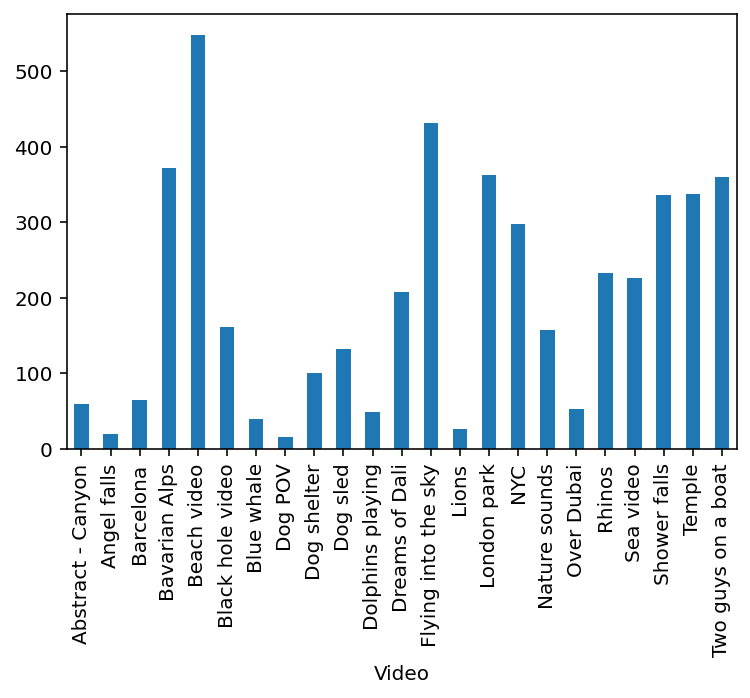

In [9]:
df.groupby('Video')['Seconds'].mean().plot.bar();

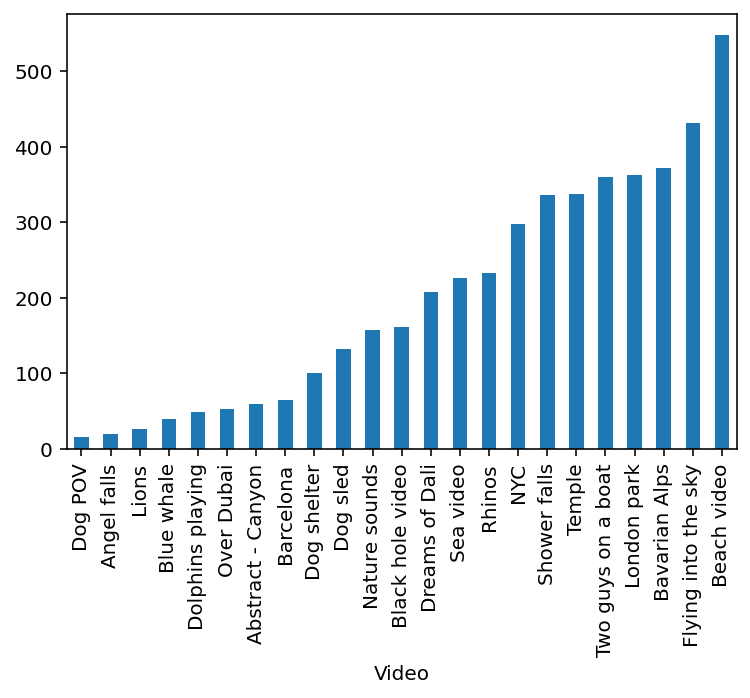

In [10]:
df.groupby('Video')['Seconds'].mean().sort_values().plot.bar();

In [11]:
500/ 60.

8.333333333333334

In [12]:
for index, row in df.iterrows():
    df.loc[index, 'Category'] = labels[row.Video]

In [13]:
df

,Day,Date,Time,Seconds,Video,Category
0,1,14/08/2021,11:02:20,6,Over Dubai,Sky
1,1,14/08/2021,19:41:28,41,Abstract - Canyon,Abstract
2,3,16/08/2021,11:08:39,5,Dog POV,Animals
3,4,17/08/2021,11:49:42,642,Black hole video,Abstract
4,4,17/08/2021,19:16:06,500,Two guys on a boat,Water
...,...,...,...,...,...,...
361,169,19/02/2022,19:54:34,2,Abstract - Canyon,Abstract
362,169,19/02/2022,19:56:38,10,Beach video,Nature
363,169,19/02/2022,20:05:50,6,Temple,Nature
364,169,19/02/2022,21:13:47,8,Shower falls,Nature


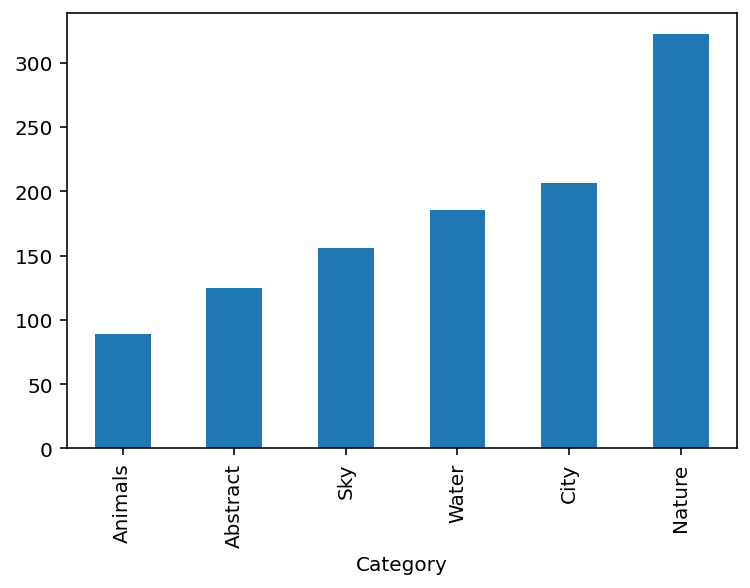

In [14]:
df.groupby('Category')['Seconds'].mean().sort_values().plot.bar();

In [15]:
df.groupby('Category')['Seconds'].mean()

Category
Abstract    124.600000
Animals      89.252874
City        206.260870
Nature      322.175439
Sky         155.863636
Water       185.546667
Name: Seconds, dtype: float64

In [16]:
df.groupby('Category')['Seconds'].std()

Category
Abstract     237.129270
Animals      259.233809
City         340.963237
Nature      1065.850504
Sky          546.174601
Water        658.012000
Name: Seconds, dtype: float64

In [35]:
from scipy.stats import sem

In [36]:
qual = df.groupby("Category")["Seconds"].agg([np.mean, sem])
qual = qual.sort_values("mean")
qual

,mean,sem
Category,,
Animals,89.252874,27.792782
Abstract,124.600000,35.349145
Sky,155.863636,116.444816
Water,185.546667,75.980681
City,206.260870,71.095750
Nature,322.175439,99.826046


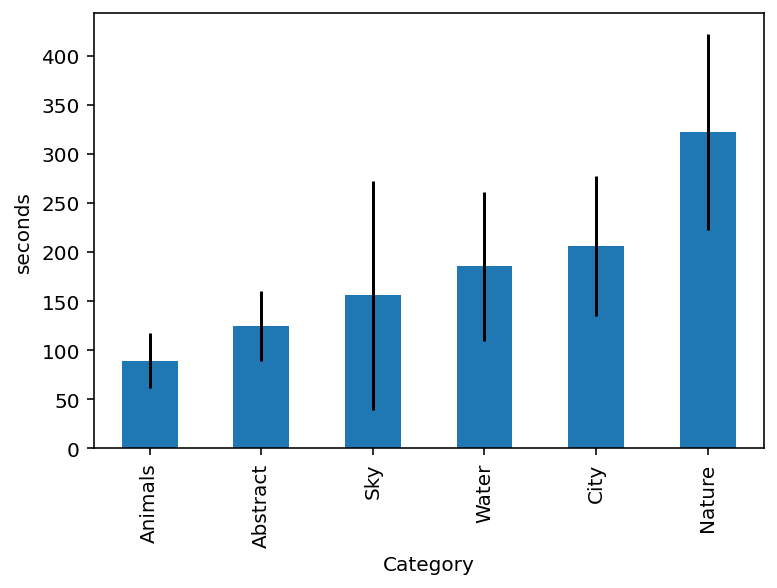

In [38]:
qual.plot(kind = "bar", y = "mean", ylabel="seconds", legend = False,
          yerr = "sem");